# Predicting If Business is Open/Close

In this portion we are going to use supervised learning to predict if a business is closed or open. 

As a first step we want to establish that the features derived are meaningful. For this we can use [featexp](https://github.com/abhayspawar/featexp) to figure out what features are most relevant. This will be useful with algorithms that perform poorly with highly dimensional data.

With our feature space reduced, we move on to prepare the data for classification. Notice that from earlier exploration we know that about ~80% of businesses are listed as open, where as 20% are closed. This 80/20 proportion must carry over to the training and testing sets.

We will evaluate each model using metrics such as:
- accuracy
- precision
- recall
- f1 score
- ROC Curve
- Precision-Recall Curve

Given that this is an imbalanced dataset, accuracy might not be the best metric. For example if we classify everything as 'open' then our accruacy will still be 80%. We might want to award more importance to recall(sensitivity), also known as the  true positive rate.

The ROC curve considers all possible thresholds for a given classifier, it shows the false positive rate against the true positive rate(recall). The ideal ROC curve is close to the top left: we want a high recall with a low FPR. We also want to summarize it with a single number known as the area under the curve.

Furthermore we consider the PR curve, the closer the curve is to the top right the better the classifier. A point in the upper right corner means high precision and high recall. The curve starts at the top left corner, corresponding to a very low threshold and with everything classified as a positive class.

Finally we understand that some algorithms are sensitive to scaling of the data and data preprocessing will be handled by calling the MinMaxScaler.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from collections import Counter, OrderedDict
import calendar
import utils, plot_help
import featexp


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve


%matplotlib inline

## Import businesses dataframes and combine in one DF

In [2]:
#change read limit to -1 to load entire dataframe
df_bus = utils.chunk_loader('data/cleaned/df_bus_conc.csv', read_limit=50_000)

In [3]:
df_bus.head()

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,...,Wednesday_close,Thursday_open,Thursday_close,Friday_open,Friday_close,Saturday_open,Saturday_close,Sunday_open,Sunday_close,state.1
0,2818 E Camino Acequia Drive,{'GoodForKids': 'False'},1SWheh84yJXfytovILXOAQ,"Golf, Active Life",Phoenix,NaN,0,33.522143,-112.018481,Arizona Biltmore Golf Club,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,30 Eglinton Avenue W,"{'RestaurantsReservations': 'True', 'GoodForMe...",QXAEGFB4oINsVuTFxEYKFQ,"Specialty Food, Restaurants, Dim Sum, Imported...",Mississauga,"{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...",1,43.605499,-79.652289,Emerald Chinese Restaurant,...,0:0,9:0,0:0,9:0,1:0,9:0,1:0,9:0,0:0,0
2,"10110 Johnston Rd, Ste 15","{'GoodForKids': 'True', 'NoiseLevel': ""u'avera...",gnKjwL_1w79qoiV3IC_xQQ,"Sushi Bars, Restaurants, Japanese",Charlotte,"{'Monday': '17:30-21:30', 'Wednesday': '17:30-...",1,35.092564,-80.859132,Musashi Japanese Restaurant,...,21:30,17:30,21:30,17:30,22:0,17:30,22:0,17:30,21:0,1
3,"15655 W Roosevelt St, Ste 237",NaN,xvX2CttrVhyG2z1dFg_0xw,"Insurance, Financial Services",Goodyear,"{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ...",1,33.455613,-112.395596,Farmers Insurance - Paul Lorenz,...,17:0,8:0,17:0,8:0,17:0,NaN,NaN,NaN,NaN,1
4,"4209 Stuart Andrew Blvd, Ste F","{'BusinessAcceptsBitcoin': 'False', 'ByAppoint...",HhyxOkGAM07SRYtlQ4wMFQ,"Plumbing, Shopping, Local Services, Home Servi...",Charlotte,"{'Monday': '7:0-23:0', 'Tuesday': '7:0-23:0', ...",1,35.190012,-80.887223,Queen City Plumbing,...,23:0,7:0,23:0,7:0,23:0,7:0,23:0,7:0,23:0,1


In [4]:
#make dataframe of numeric types
df_bus_numeric = df_bus.select_dtypes(include=[np.float64, np.int64]).copy()
df_bus_numeric.shape

(50000, 125)

## Split in Training & Test Data

In [5]:
#training data and target
X = df_bus_numeric.drop(columns=['is_open'])
y = df_bus_numeric.is_open

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

In [6]:
#check stratification is close enough to 1/1000 tolerance
assert np.isclose(np.mean(y_train), np.mean(y_test), rtol=1e-3)

In [7]:
#instantiate a scaler
scaler = MinMaxScaler()

#fit scaler to training data
scaler.fit(X_train)
X_train = scaler.transform(X_train)

#fit apply similar scale to test data
X_test = scaler.transform(X_test)

/Users/nadimkawwa/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [8]:
#assert scaling worked on training data
assert np.max(X_train)== 1
assert np.min(X_train) ==0

In [9]:
#we can tell how representative the training set is by looking at the scaled test data
print("Max value of scaled test data = {}".format(np.max(X_test)))
print("Min value of scaled test data = {}".format(np.min(X_test)))

Max value of scaled test data = 1.0
Min value of scaled test data = 0.0


## Explore Features with featexp

In [10]:
#set up training df to match featexp expected format
# data_train = X_train.reset_index(drop=True)
# data_train['target'] = y_train.reset_index(drop=True)
# data_test = X_test.reset_index(drop=True)
# data_test['target'] = y_test.reset_index(drop=True)

In [11]:
# Plots drawn for all features if nothing is passed in feature_list parameter.
# featexp.get_univariate_plots(data=data_train, target_col='target', bins=10)

In [12]:
#get trend stats
# stats = featexp.get_trend_stats(data=data_train, target_col='target', data_test=data_test)

In [13]:
# stats[(stats['Trend_correlation']<0.9) & (stats['Trend_correlation']>-0.9)]

## Logistic Regression

In [14]:
#instantiate logistic regression and fit to training data
log_reg = LogisticRegression(penalty='l2',
                             solver='liblinear',
                             class_weight='balanced')
#fit to training data
log_reg.fit(X_train, y_train)

#make prediction
y_log_reg = log_reg.predict(X_test)

#get accruacy
print(np.mean(y_log_reg==y_test))

0.71944


In [15]:
print(classification_report(y_test, y_log_reg))

              precision    recall  f1-score   support

           0       0.34      0.62      0.44      2226
           1       0.90      0.74      0.81     10274

   micro avg       0.72      0.72      0.72     12500
   macro avg       0.62      0.68      0.63     12500
weighted avg       0.80      0.72      0.75     12500



In [16]:
print(confusion_matrix(y_test, y_log_reg))

[[1381  845]
 [2662 7612]]


Confusion matrix, without normalization


/Users/nadimkawwa/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


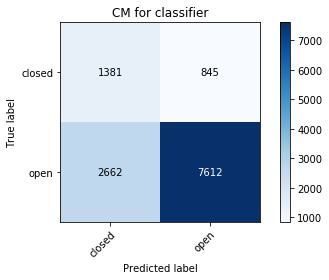

In [17]:
plot_help.plot_confusion_matrix(y_test, y_log_reg, ['closed', 'open'])

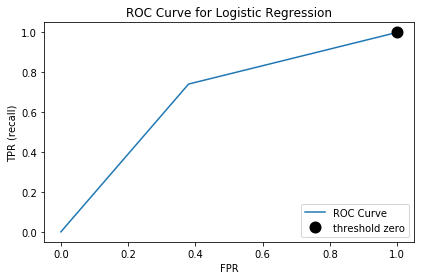

0.6806473427721054


In [18]:
plot_help.plot_roc_curve(y_test, y_log_reg, 'Logistic Regression')

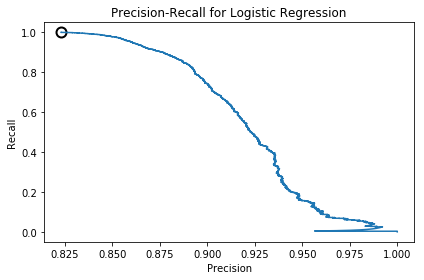

In [19]:
plot_help.plot_prc_curve(y_test, log_reg.predict_proba(X_test)[:, 1], 'Logistic Regression')

## KNN

In [20]:
#instantaite knn
knn = KNeighborsClassifier(n_neighbors=5)

#fit to training data
knn.fit(X_train, y_train)

#make prediction
y_knn_pred = knn.predict(X_test)

In [21]:
np.mean(y_knn_pred==y_test)

0.82352

              precision    recall  f1-score   support

           0       0.51      0.27      0.35      2226
           1       0.86      0.94      0.90     10274

   micro avg       0.82      0.82      0.82     12500
   macro avg       0.68      0.61      0.63     12500
weighted avg       0.79      0.82      0.80     12500

----------
Confusion matrix, without normalization


/Users/nadimkawwa/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


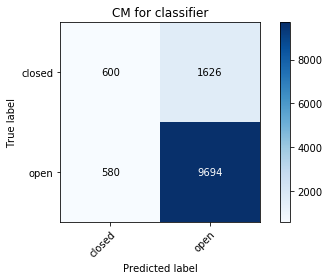

----------


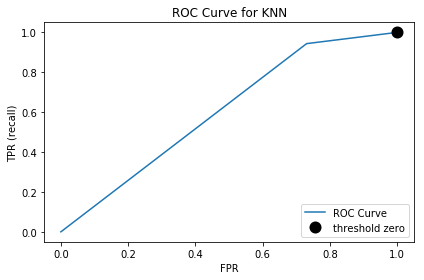

0.6065442980921144
----------


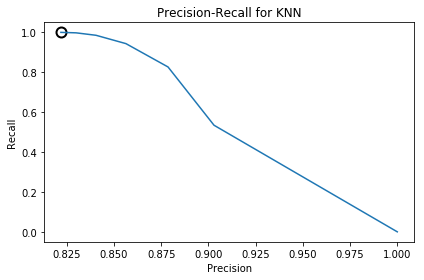

In [22]:
print(classification_report(y_test, y_knn_pred))
print(10*'-')
plot_help.plot_confusion_matrix(y_test, y_knn_pred, ['closed', 'open'])
print(10*'-')
plot_help.plot_roc_curve(y_test, y_knn_pred, 'KNN')
print(10*'-')
plot_help.plot_prc_curve(y_test, knn.predict_proba(X_test)[:, 1], 'KNN')

## Naive Bayes

In [23]:
#instantaite nb
nb = GaussianNB()

#fit to training data
nb.fit(X_train, y_train)

#make prediction
y_nb_pred = nb.predict(X_test)

print(np.mean(y_nb_pred==y_test))

0.2476


              precision    recall  f1-score   support

           0       0.19      0.97      0.31      2226
           1       0.93      0.09      0.17     10274

   micro avg       0.25      0.25      0.25     12500
   macro avg       0.56      0.53      0.24     12500
weighted avg       0.79      0.25      0.19     12500

----------
Confusion matrix, without normalization


/Users/nadimkawwa/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


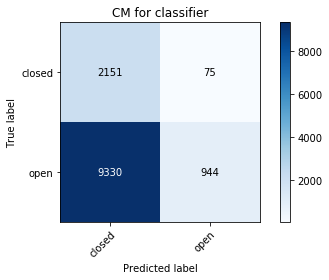

----------


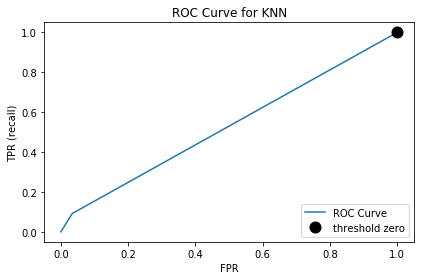

0.529094849637454
----------


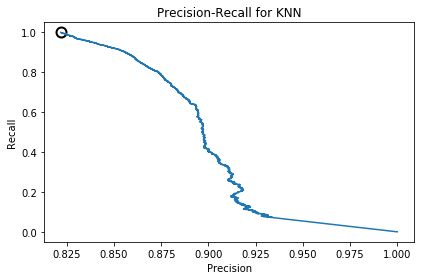

In [24]:
print(classification_report(y_test, y_nb_pred))
print(10*'-')
plot_help.plot_confusion_matrix(y_test, y_nb_pred, ['closed', 'open'])
print(10*'-')
plot_help.plot_roc_curve(y_test, y_nb_pred, 'KNN')
print(10*'-')
plot_help.plot_prc_curve(y_test, nb.predict_proba(X_test)[:, 1], 'KNN')

## Decision Trees Ensembles:  Random Forest

In [25]:
#instantaite random forest
rf = RandomForestClassifier(n_estimators=400,
                            max_depth=40, 
                            min_samples_split=15, 
                            min_samples_leaf=5,
                            n_jobs=-1)

#fit to training data
rf.fit(X_train, y_train)

#make prediction
y_rf_pred = rf.predict(X_test)

print(np.mean(y_rf_pred==y_test))

0.84528


              precision    recall  f1-score   support

           0       0.84      0.16      0.27      2226
           1       0.85      0.99      0.91     10274

   micro avg       0.85      0.85      0.85     12500
   macro avg       0.84      0.58      0.59     12500
weighted avg       0.84      0.85      0.80     12500

----------
Confusion matrix, without normalization


/Users/nadimkawwa/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


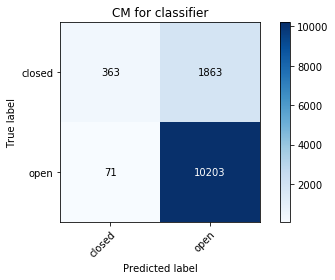

----------


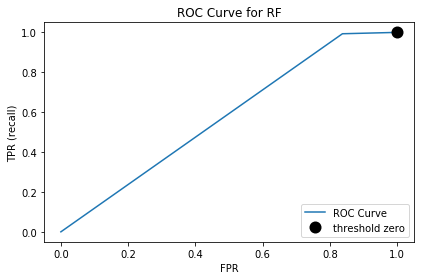

0.578081064021026
----------


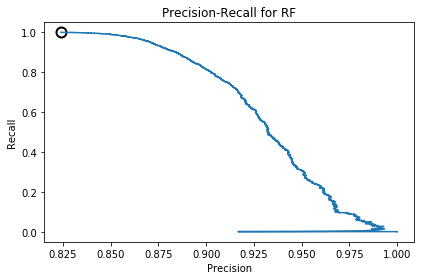

In [26]:
print(classification_report(y_test, y_rf_pred))
print(10*'-')
plot_help.plot_confusion_matrix(y_test, y_rf_pred, ['closed', 'open'])
print(10*'-')
plot_help.plot_roc_curve(y_test, y_rf_pred, 'RF')
print(10*'-')
plot_help.plot_prc_curve(y_test, rf.predict_proba(X_test)[:, 1], 'RF')

## Decision Trees Ensembles:  Gradient Boosted Regression Trees

In [27]:
#instantiate gradient boosting
gbrt = GradientBoostingClassifier(n_estimators=400,
                                  min_samples_split=100,
                                  min_samples_leaf=10)

#fit to training data
gbrt.fit(X_train, y_train)

#make prediction
y_gbrt_pred = gbrt.predict(X_test)

print(np.mean(y_gbrt_pred==y_test))

0.85352


              precision    recall  f1-score   support

           0       0.74      0.27      0.40      2226
           1       0.86      0.98      0.92     10274

   micro avg       0.85      0.85      0.85     12500
   macro avg       0.80      0.63      0.66     12500
weighted avg       0.84      0.85      0.82     12500

----------
Confusion matrix, without normalization


/Users/nadimkawwa/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


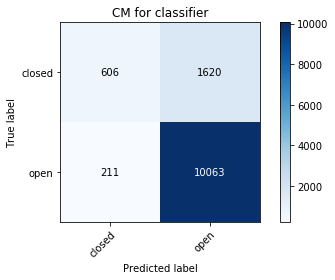

----------


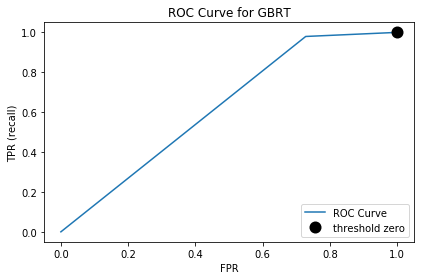

0.6258499590991207
----------


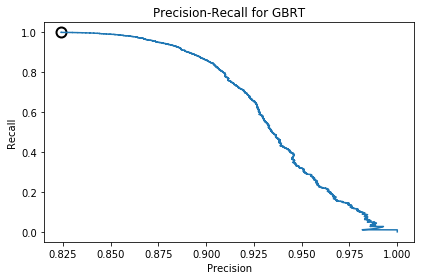

In [28]:
print(classification_report(y_test, y_gbrt_pred))
print(10*'-')
plot_help.plot_confusion_matrix(y_test, y_gbrt_pred, ['closed', 'open'])
print(10*'-')
plot_help.plot_roc_curve(y_test, y_gbrt_pred, 'GBRT')
print(10*'-')
plot_help.plot_prc_curve(y_test, gbrt.predict_proba(X_test)[:, 1], 'GBRT')

## Kernalized Support Vector Machines

In [29]:
#instantiate SVM
svm = SVC(C=1, 
          kernel='rbf', 
          gamma=0.1)

#fit to training data
svm.fit(X_train, y_train)

#make prediction
y_svm_pred = svm.predict(X_test)

print(np.mean(y_svm_pred==y_test))

0.84616


              precision    recall  f1-score   support

           0       0.75      0.20      0.32      2226
           1       0.85      0.99      0.91     10274

   micro avg       0.85      0.85      0.85     12500
   macro avg       0.80      0.59      0.62     12500
weighted avg       0.83      0.85      0.81     12500

----------
Confusion matrix, without normalization


/Users/nadimkawwa/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


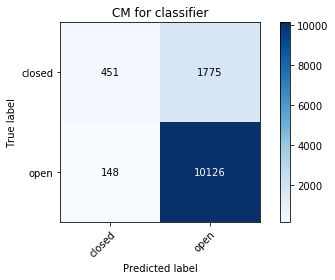

----------


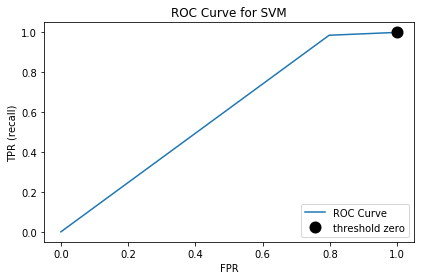

0.5941001378054427
----------


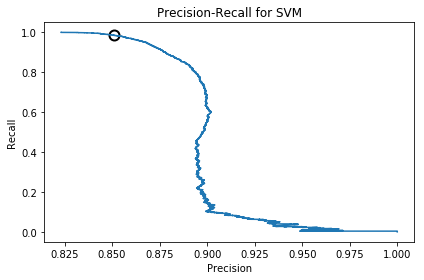

In [31]:
print(classification_report(y_test, y_svm_pred))
print(10*'-')
plot_help.plot_confusion_matrix(y_test, y_svm_pred, ['closed', 'open'])
print(10*'-')
plot_help.plot_roc_curve(y_test, y_svm_pred, 'SVM')
print(10*'-')
#notice we use decision function for svm
plot_help.plot_prc_curve(y_test, svm.decision_function(X_test), 'SVM')

In [ ]:
# #build parameter grid for logistic regression
# lr_param_grid = {'tol': [1e-4, 1e-3],
#                  'C': [0.01, 0.1, 1, 10, 100]}

# #instantiate grid search cv object
# lr_grid_cv = GridSearchCV(estimator = LogisticRegression(solver='liblinear'), #other solvers may not converge
#                        param_grid=lr_param_grid,
#                        n_jobs=-1, #use all cpu cores
#                        cv=5)
# #fit to training data
# lr_grid_cv.fit(X_train, y_train)

# yr_lr_cv = lr_grid_cv.predict(X_test)
# print(np.mean(yr_lr_cv==y_test))